## DO NOT RUN THIS NOTEBOOK

### We ran this notebook on kaggle (for gpu boost), to create the model with hyperparameter tuning

Célestin GABORIAU, Anaëlle MARTY, Alix MEULOT, Timothée POULY

We used AI (especially Copilot auto completion and Chat GPT) to help us coding. Nevertheless, we understand what is done and we debugged a lot of issues. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Ignore the print statements, it just to confirm the code ran successfully on kaggle
a = 'ok'

In [ ]:
import os
import cv2
import yaml
import shutil
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import Dataset
from PIL import Image
import torch
import sys
# print(torch.cuda.is_available())

from ultralytics import YOLO
sys.path.append("../src")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
oik


In [ ]:

def pair_split(image_split_dir, label_split_dir):
    pairs = []
    for img in os.listdir(image_split_dir):
        if img.lower().endswith(('.jpg', '.png', '.jpeg')):
            label = os.path.splitext(img)[0] + ".txt"
            label_path = os.path.join(label_split_dir, label)
            if os.path.exists(label_path):
                pairs.append((os.path.join(image_split_dir, img), label_path))
    return pairs


def display_image_with_bboxes(img, targets):
    print(f"Number of objects in this image: {len(targets)}")
    # COCO stores bbox as [x, y, width, height]
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(img.permute(1, 2, 0))  # CHW -> HWC

    for t in targets:
        x, y, w, h = t.numpy()
        rect = patches.Rectangle(
            (x, y),
            w,
            h,
            linewidth=2,
            edgecolor="red",
            facecolor="none",
        )
        ax.add_patch(rect)

    plt.axis("off")
    plt.show()

    import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_yolo_sample(img_tensor, label_matrix, S=7):
    # 1. Préparer l'image : [C, H, W] -> [H, W, C]
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(img)
    
    H, W, _ = img.shape

    # 2. Dessiner la grille (optionnel, pour debug)
    for l in range(S + 1):
        ax.axhline(l * (H/S), color='white', lw=0.5, alpha=0.3)
        ax.axvline(l * (W/S), color='white', lw=0.5, alpha=0.3)

    # 3. Parcourir la grille
    for i in range(S):     # Lignes (y)
        for j in range(S): # Colonnes (x)
            # On vérifie si un objet est présent (confiance == 1)
            if label_matrix[i, j, 4] == 1:
                # Récupérer les coordonnées relatives à la cellule
                x_cell, y_cell, w, h = label_matrix[i, j, 0:4]
                
                # Reconvertir en coordonnées normalisées globales (0 à 1)
                xc = (x_cell + j) / S
                yc = (y_cell + i) / S
                
                # Convertir en pixels pour Matplotlib
                # (YOLO utilise le centre, Matplotlib utilise le coin haut-gauche)
                width_pix = w * W
                height_pix = h * H
                x_min = (xc * W) - (width_pix / 2)
                y_min = (yc * H) - (height_pix / 2)
                
                # Créer le rectangle
                rect = patches.Rectangle(
                    (x_min, y_min), width_pix, height_pix, 
                    linewidth=2, edgecolor='red', facecolor='none'
                )
                ax.add_patch(rect)
                
                # Ajouter un petit point au centre pour vérifier la cellule
                ax.plot(xc * W, yc * H, 'ro', markersize=3)

    plt.title(f"Visualisation Grille {S}x{S}")
    plt.axis('off')
    plt.show()


ok


In [ ]:
image_dir = "/kaggle/input/dataset-small1/dataset_small1/images"
label_dir = "/kaggle/input/dataset-small1/dataset_small1/labels"


ok


In [7]:
train_pairs = pair_split(image_dir+"/train", label_dir+"/train")
val_pairs   = pair_split(image_dir+"/val", label_dir+"/val")
test_pairs  = pair_split(image_dir+"/test", label_dir+"/test")

In [ ]:
import os
from PIL import Image

def process_pairs_to_normalized_dataset(pairs):
    dataset_list = []

    for img_path, label_path in pairs:
        # Charger l'image
        try:
            img_pil = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            continue

        bboxes = []
        class_ids = []

        # Lire le fichier label YOLO (format: class xc yc w h)
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if not parts: continue
                    
                    c, xc, yc, w, h = map(float, parts)
                    
                    # On garde les valeurs telles quelles (normalisées)
                    bboxes.append([xc, yc, w, h])
                    class_ids.append(int(c))
        
        dataset_list.append((img_pil, bboxes, class_ids))

    return dataset_list


ok


In [9]:
train_dataset = process_pairs_to_normalized_dataset(train_pairs)
val_dataset   = process_pairs_to_normalized_dataset(val_pairs)
test_dataset  = process_pairs_to_normalized_dataset(test_pairs)

In [ ]:
class YoloDataset(Dataset):
    def __init__(self, pairs, transform, S=13):
        self.pairs = pairs              # (img_path, label_path)
        self.transform = transform
        self.S = S

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, label_path = self.pairs[idx]

        # 1. Image
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        # 2. Label matrix
        label_matrix = torch.zeros((self.S, self.S, 5))


        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f:
                    c, xc, yc, w, h = map(float, line.split())

                    i = min(int(yc * self.S), self.S - 1)
                    j = min(int(xc * self.S), self.S - 1)


                    label_matrix[i, j, 4] = 1.0
                    label_matrix[i, j, 0:4] = torch.tensor([
                        xc * self.S - j,
                        yc * self.S - i,
                        w, h
                    ])
                    

        return img, label_matrix


ok


In [ ]:
import torchvision.transforms as transforms

# Définissez une taille standard (YOLO utilise souvent 416 ou 640)
IMAGE_SIZE = 416 

my_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # Redimensionne TOUTES les images
    transforms.ToTensor(),                        # Convertit en [0, 1]
])

# Appliquez ces transformations à vos datasets
train_ds = YoloDataset(train_pairs, transform=my_transforms, S=13)
val_ds   = YoloDataset(val_pairs,   transform=my_transforms, S=13)
test_ds  = YoloDataset(test_pairs,  transform=my_transforms, S=13)


ok


Image tensor shape: torch.Size([3, 416, 416])
Label matrix shape: torch.Size([13, 13, 5])


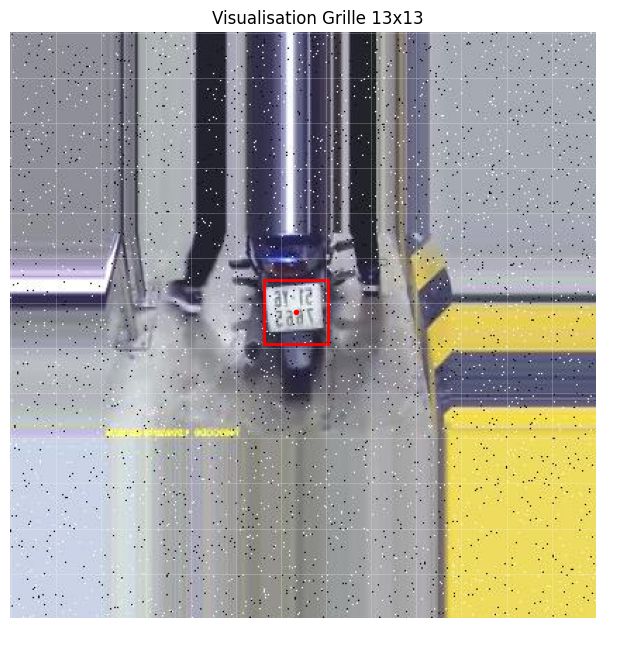

In [13]:
img, label = train_ds[10] 
print("Image tensor shape:", img.shape)
print("Label matrix shape:", label.shape)
plot_yolo_sample(img, label, S=13)

In [ ]:
from torch.utils.data import DataLoader # a importer en début de notebook
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)


ok


In [15]:
import torch
import torch.nn as nn

class YOLOv1(nn.Module):
    def __init__(self, S=13, C=1):
        super().__init__()
        self.S = S
        self.C = C
        self.out_channels = 5 + C  # x,y,w,h,obj + classes

        # ✅ TOUT doit être indenté ici
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 7, 2, 3),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 192, 3, 1, 1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(192, 128, 1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 256, 1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),

            *[nn.Sequential(
                nn.Conv2d(512, 256, 1),
                nn.LeakyReLU(0.1),
                nn.Conv2d(256, 512, 3, 1, 1),
                nn.LeakyReLU(0.1)
            ) for _ in range(4)],

            nn.Conv2d(512, 1024, 3, 1, 1),
            nn.LeakyReLU(0.1),

            # 🔥 FIX CRITIQUE
            nn.MaxPool2d(2, 2),  # 26×26 → 13×13
        )

        self.pred_head = nn.Conv2d(1024, self.out_channels, 1)

    def forward(self, x):
        x = self.features(x)
        x = self.pred_head(x)

        # 🔒 sécurité dimensionnelle
        assert x.shape[2] == self.S and x.shape[3] == self.S, \
            f"Output grid {x.shape[2:]} ≠ S={self.S}"

        x = x.permute(0, 2, 3, 1)

        # 🔑 contraintes YOLO
        x[..., 0:2] = torch.sigmoid(x[..., 0:2])  # x,y
        x[..., 2:4] = torch.sigmoid(x[..., 2:4])  # w,h
        x[..., 4]   = torch.sigmoid(x[..., 4])    # objectness

        return x


In [16]:
test = YOLOv1(S=7, C=1)
print(test)

YOLOv1(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): LeakyReLU(negative_slope=0.1)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.1)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.1)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.1)
    (10): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (11): LeakyReLU(negative_slope=0.1)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): LeakyReLU(negative_slope=0.1)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Sequential(
      (0): Conv2d(512, 256,

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = YOLOv1(S=13, C=1).to(device)

bbox_loss_fn = nn.MSELoss() 
cls_loss_fn = nn.CrossEntropyLoss()  

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

loss_history = []


ok


In [18]:
def yolo_loss(pred, target, lambda_coord=5, lambda_noobj=0.5):
    obj_mask   = target[..., 4] == 1
    noobj_mask = target[..., 4] == 0

    # --- COORD LOSS ---
    if obj_mask.sum() > 0:
        loss_xy = ((pred[...,0:2] - target[...,0:2])**2)[obj_mask].mean()

        loss_wh = ((torch.sqrt(pred[...,2:4] + 1e-6) -
                    torch.sqrt(target[...,2:4] + 1e-6))**2)[obj_mask].mean()
    else:
        loss_xy = loss_wh = torch.tensor(0.0, device=pred.device)

    # --- OBJECTNESS LOSS ---
    loss_obj = F.binary_cross_entropy(pred[...,4][obj_mask],
                                      target[...,4][obj_mask]) \
               if obj_mask.sum() > 0 else torch.tensor(0.0, device=pred.device)

    loss_noobj = F.binary_cross_entropy(pred[...,4][noobj_mask],
                                        target[...,4][noobj_mask]) \
                 if noobj_mask.sum() > 0 else torch.tensor(0.0, device=pred.device)

    return lambda_coord*(loss_xy + loss_wh) + loss_obj + lambda_noobj*loss_noobj


In [19]:
import torch.nn.functional as F

img, label = train_ds[0]
img = img.unsqueeze(0).to(device)
label = label.unsqueeze(0).to(device)

model = YOLOv1(S=13, C=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for step in range(500):
    pred = model(img)
    loss = yolo_loss(pred, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 50 == 0:
        print(f"Step {step} | Loss {loss.item():.6f}")



Step 0 | Loss 2.081768
Step 50 | Loss 1.364927
Step 100 | Loss 0.671159
Step 150 | Loss 0.093682
Step 200 | Loss 0.025851
Step 250 | Loss 0.024823
Step 300 | Loss 0.024772
Step 350 | Loss 0.024753
Step 400 | Loss 0.024743
Step 450 | Loss 0.024736


In [20]:
import itertools
import random
'''
# --- HYPERPARAMETERS A TESTER ---
learning_rates = [1e-3, 5e-4, 1e-4]
batch_sizes = [16, 32, 64]
lambda_coords = [5, 3]
lambda_noobjs = [0.5, 0.3]
num_epochs = 6  # epochs max pour le test rapide

# --- COMBINAISONS ---
param_combinations = list(itertools.product(learning_rates, batch_sizes, lambda_coords, lambda_noobjs))

# --- ÉCHANTILLON DE 10 COMBINAISONS ---
random.seed(42)  # pour reproductibilité
param_combinations = random.sample(param_combinations, 10)

# --- STOCKAGE DES RESULTATS ---
results = []

for lr, bs, lc, lno in param_combinations:
    print(f"\n=== Test: lr={lr}, batch_size={bs}, lambda_coord={lc}, lambda_noobj={lno} ===")
    
    # Dataloaders
    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=bs, shuffle=False)
    
    # Nouveau modèle
    model = YOLOv1(S=13, C=1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Training loop minimal
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        # Train
        model.train()
        total_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            preds = model(imgs)
            loss = yolo_loss(preds, labels, lambda_coord=lc, lambda_noobj=lno)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)
        
        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for imgs_v, labels_v in val_loader:
                imgs_v, labels_v = imgs_v.to(device), labels_v.to(device)
                preds_v = model(imgs_v)
                v_loss = yolo_loss(preds_v, labels_v, lambda_coord=lc, lambda_noobj=lno)
                total_val_loss += v_loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
        
        # Affichage par epoch pour suivre la progression
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.3f} | Val Loss: {avg_val_loss:.3f}")

    results.append({
        "lr": lr, "batch_size": bs, "lambda_coord": lc, "lambda_noobj": lno,
        "best_val_loss": best_val_loss
    })
    print(f"Best Val Loss for this combo: {best_val_loss:.3f}")

# --- TRI ET AFFICHAGE ---
results = sorted(results, key=lambda x: x["best_val_loss"])
best_params = results[0]
print("\n=== Top Hyperparameter Set ===")
print(best_params)
'''

'\n# --- HYPERPARAMETERS A TESTER ---\nlearning_rates = [1e-3, 5e-4, 1e-4]\nbatch_sizes = [16, 32, 64]\nlambda_coords = [5, 3]\nlambda_noobjs = [0.5, 0.3]\nnum_epochs = 6  # epochs max pour le test rapide\n\n# --- COMBINAISONS ---\nparam_combinations = list(itertools.product(learning_rates, batch_sizes, lambda_coords, lambda_noobjs))\n\n# --- ÉCHANTILLON DE 10 COMBINAISONS ---\nrandom.seed(42)  # pour reproductibilité\nparam_combinations = random.sample(param_combinations, 10)\n\n# --- STOCKAGE DES RESULTATS ---\nresults = []\n\nfor lr, bs, lc, lno in param_combinations:\n    print(f"\n=== Test: lr={lr}, batch_size={bs}, lambda_coord={lc}, lambda_noobj={lno} ===")\n    \n    # Dataloaders\n    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True)\n    val_loader   = DataLoader(val_ds, batch_size=bs, shuffle=False)\n    \n    # Nouveau modèle\n    model = YOLOv1(S=13, C=1).to(device)\n    optimizer = torch.optim.Adam(model.parameters(), lr=lr)\n    \n    # Training loop minim

In [ ]:
# After running the hyperparameter search, we found:
best_params = {'lr': 0.0005, 'batch_size': 16, 'lambda_coord': 3, 'lambda_noobj': 0.5, 'best_val_loss': 0.975434523820877}

In [22]:
# --- Boucle d'entraînement avec EarlyStopping et best_params ---
model = YOLOv1(S=13, C=1).to(device)

# --- Paramètres optimisés ---
lr = best_params["lr"]
batch_size = best_params["batch_size"]
lambda_coord = best_params["lambda_coord"]
lambda_noobj = best_params["lambda_noobj"]

# --- Dataloaders ---
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_loss_history = []
val_loss_history = []

# --- EarlyStopping ---
patience = 5
best_val_loss = float('inf')
counter = 0

num_epochs = 30
for epoch in range(num_epochs):

    # ============================
    # 1. PHASE ENTRAÎNEMENT
    # ============================
    model.train()
    total_train_loss = 0
    num_batches = 0

    for imgs, labels in train_loader:
        imgs   = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        preds = model(imgs)

        loss = yolo_loss(
            preds, labels,
            lambda_coord=lambda_coord,
            lambda_noobj=lambda_noobj
        )

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        num_batches += 1

    avg_train_loss = total_train_loss / num_batches
    train_loss_history.append(avg_train_loss)

    # ============================
    # 2. PHASE VALIDATION
    # ============================
    model.eval()
    total_val_loss = 0
    num_val_batches = 0

    with torch.no_grad():
        for imgs_v, labels_v in val_loader:
            imgs_v   = imgs_v.to(device)
            labels_v = labels_v.to(device)

            preds_v = model(imgs_v)

            v_loss = yolo_loss(
                preds_v, labels_v,
                lambda_coord=lambda_coord,
                lambda_noobj=lambda_noobj
            )

            total_val_loss += v_loss.item()
            num_val_batches += 1

    avg_val_loss = total_val_loss / num_val_batches
    val_loss_history.append(avg_val_loss)

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train Loss: {avg_train_loss:.4f} | "
        f"Val Loss: {avg_val_loss:.4f}"
    )

    # ============================
    # 3. EARLY STOPPING
    # ============================
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        os.makedirs("models", exist_ok=True)
        torch.save(model.state_dict(), "models/best_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print(f"EarlyStopping déclenché à l’epoch {epoch+1}")
            break


Epoch 01 | Train Loss: 1.2726 | Val Loss: 1.3193
Epoch 02 | Train Loss: 1.7490 | Val Loss: 1.3221
Epoch 03 | Train Loss: 1.1121 | Val Loss: 1.4216
Epoch 04 | Train Loss: 0.8654 | Val Loss: 1.0963
Epoch 05 | Train Loss: 0.7050 | Val Loss: 1.1278
Epoch 06 | Train Loss: 0.6634 | Val Loss: 1.0899
Epoch 07 | Train Loss: 0.6315 | Val Loss: 1.1847
Epoch 08 | Train Loss: 0.6259 | Val Loss: 1.1046
Epoch 09 | Train Loss: 0.5918 | Val Loss: 1.0132
Epoch 10 | Train Loss: 0.5980 | Val Loss: 0.9974
Epoch 11 | Train Loss: 0.5888 | Val Loss: 1.1806
Epoch 12 | Train Loss: 0.5878 | Val Loss: 1.0399
Epoch 13 | Train Loss: 0.5238 | Val Loss: 0.9400
Epoch 14 | Train Loss: 0.4984 | Val Loss: 1.2273
Epoch 15 | Train Loss: 0.4706 | Val Loss: 1.0696
Epoch 16 | Train Loss: 0.4625 | Val Loss: 0.9656
Epoch 17 | Train Loss: 0.4475 | Val Loss: 0.9652
Epoch 18 | Train Loss: 0.4689 | Val Loss: 1.0414
EarlyStopping déclenché à l’epoch 18


In [23]:
# Chargement du meilleur modèle
model.load_state_dict(torch.load("models/best_model.pth"))

<All keys matched successfully>

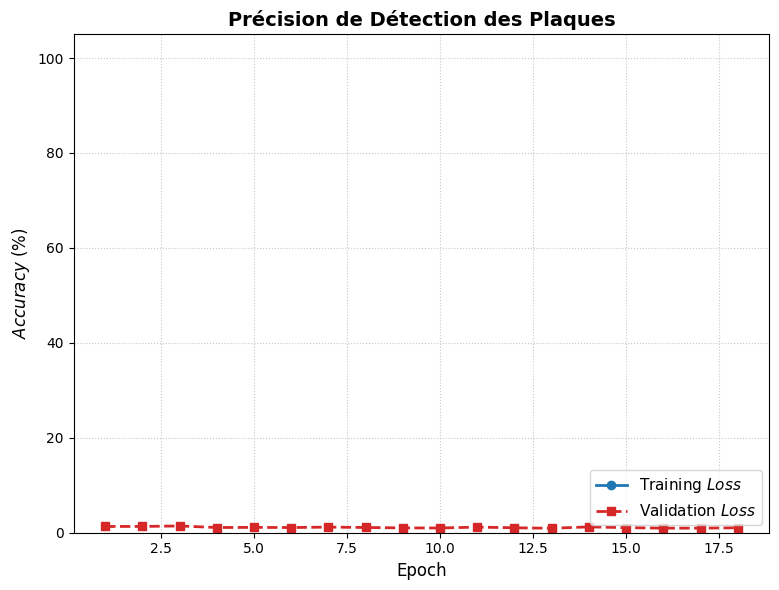

In [24]:
import matplotlib.pyplot as plt

# Configuration du style
plt.figure(figsize=(15, 6))

# --- GRAPHIQUE 1 : LOSS (Erreur) ---
plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss_history) + 1), loss_history, 
         label='Training $Loss$', color='#1f77b4', marker='o', linewidth=2)
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, 
         label='Validation $Loss$', color='#d62728', marker='s', linestyle='--', linewidth=2)

plt.title("Évolution de la Perte ($YOLO$ $Loss$)", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("$Loss$", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle=':', alpha=0.7)





plt.title("Précision de Détection des Plaques", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("$Accuracy$ (%)", fontsize=12)
plt.ylim(0, 105) # Pour bien voir la progression jusqu'à 100%
plt.legend(fontsize=11, loc='lower right')
plt.grid(True, linestyle=':', alpha=0.7)

plt.tight_layout()

# Sauvegarde pour tes slides
plt.savefig("courbes_apprentissage_yolo.png", dpi=300)
plt.show()

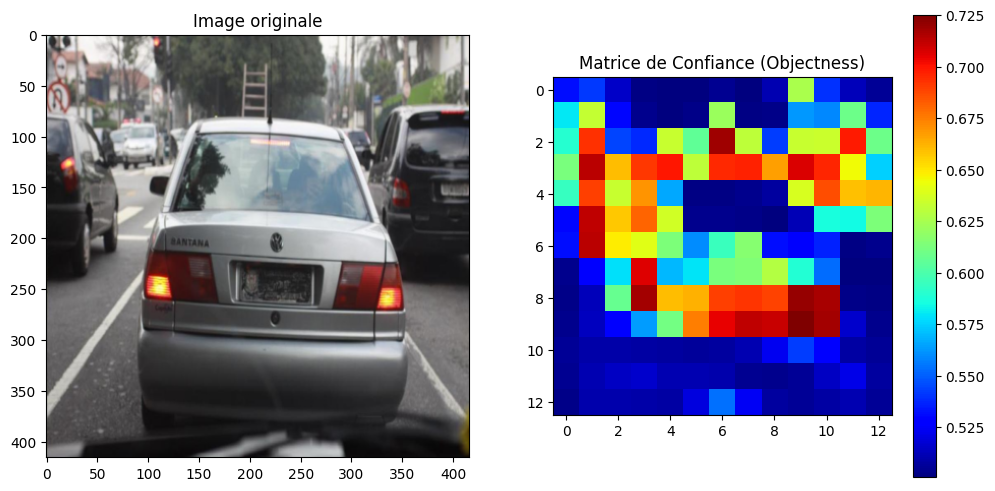

In [25]:
# Visualisation de la matrice de confiance (objectness) pour une image du dataset de validation

def plot_confidence_heatmap(model, dataset, idx=0):
    model.eval()
    img, target = dataset[idx]
    
    # Prédiction (on ajoute une dimension batch et on envoie sur le bon device)
    with torch.no_grad():
        prediction = model(img.unsqueeze(0).to(device))
    
    # On récupère le score d'objectness (canal 4) et on applique sigmoid
    # La forme est (1, 13, 13, 6) -> on veut (13, 13)
    conf_map = torch.sigmoid(prediction[0, ..., 4]).cpu().numpy()

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # Image originale
    ax[0].imshow(img.permute(1, 2, 0))
    ax[0].set_title("Image originale")
    
    # Heatmap
    im = ax[1].imshow(conf_map, cmap='jet')
    ax[1].set_title("Matrice de Confiance (Objectness)")
    plt.colorbar(im, ax=ax[1])
    plt.show()

# Utilisation
plot_confidence_heatmap(model, val_ds, idx=1)

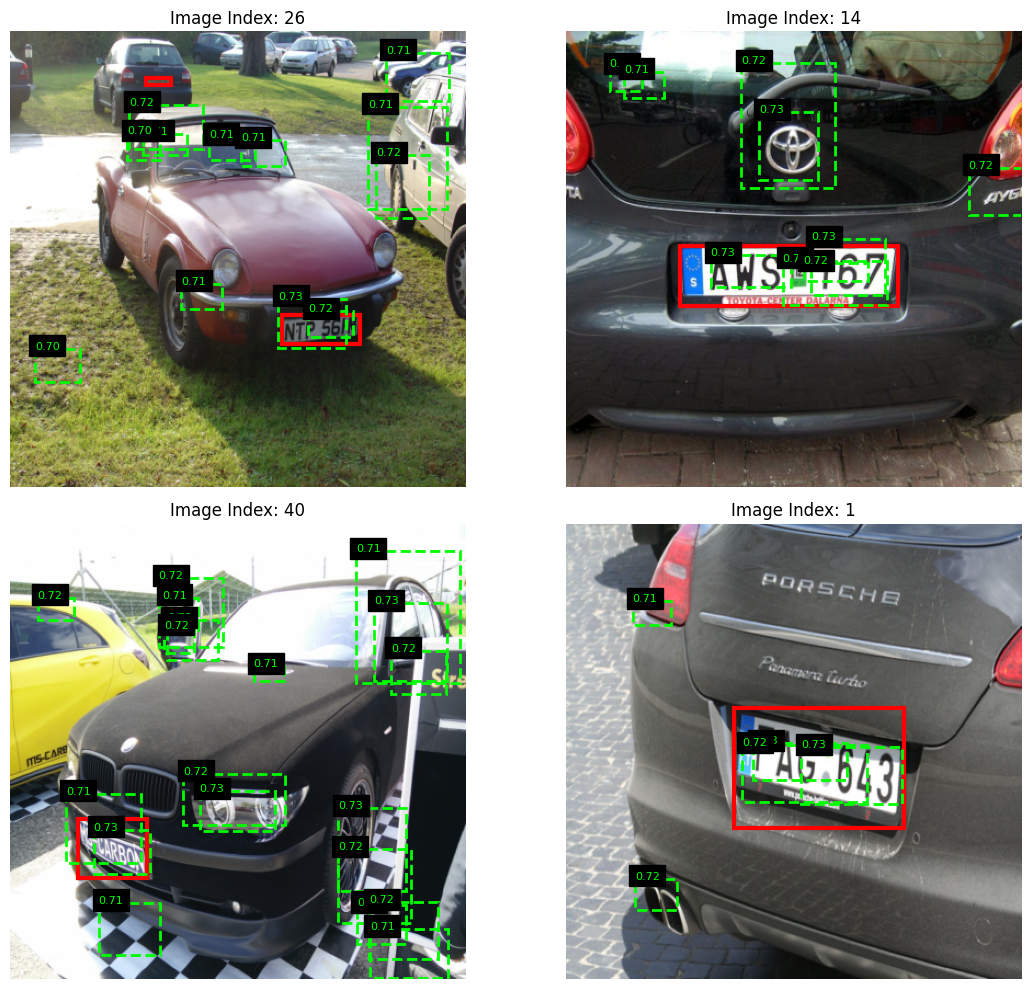

In [26]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

# 1. PARAMETRES (A vérifier selon ton code)
S_GRID = 13
IMG_SIZE = 416
id_to_name = {0: "Plaque"} # Ajuste si ton label commence à 1

# ==========================================
# 2. FONCTIONS DE CALCUL (IoU & NMS)
# ==========================================
def iou(box1, box2):
    # box format: [x_center, y_center, w, h] (normalized 0-1)
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    x1a, y1a = x1 - w1/2, y1 - h1/2
    x1b, y1b = x1 + w1/2, y1 + h1/2
    x2a, y2a = x2 - w2/2, y2 - h2/2
    x2b, y2b = x2 + w2/2, y2 + h2/2

    xi1, yi1 = max(x1a, x2a), max(y1a, y2a)
    xi2, yi2 = min(x1b, x2b), min(y1b, y2b)
    
    inter = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    union = (w1 * h1) + (w2 * h2) - inter
    return inter / (union + 1e-6)

def apply_nms(boxes, scores, iou_thresh=0.45):
    if len(boxes) == 0: return []
    
    # Tri par score de confiance
    idxs = scores.argsort(descending=True)
    keep = []
    
    while len(idxs) > 0:
        curr = idxs[0].item()
        keep.append(curr)
        if len(idxs) == 1: break
        
        # On ne garde que les boites dont l'IoU avec la boite actuelle est faible
        rem_idxs = idxs[1:]
        ious = torch.tensor([iou(boxes[curr], boxes[i.item()]) for i in rem_idxs])
        mask = ious < iou_thresh
        idxs = rem_idxs[mask]
        
    return keep

# ==========================================
# 3. DECODAGE DE LA GRILLE (Le secret du placement)
# ==========================================
def decode_yolo_grid(tensor, S=13, is_target=False):
    boxes, scores, classes = [], [], []
    
    for i in range(S):
        for j in range(S):
            cell = tensor[i, j]

            conf = cell[4].item() if is_target else torch.sigmoid(cell[4]).item()
            if conf < 0.1:
                continue

            px, py, pw, ph = cell[0:4]
            gx = (j + px) / S
            gy = (i + py) / S

            boxes.append([gx.item(), gy.item(), pw.item(), ph.item()])
            scores.append(conf)

            if is_target:
                classes.append(0)  # target = classe unique
            else:
                classes.append(int(cell[5].item()))  # prediction

    return torch.tensor(boxes), torch.tensor(scores), torch.tensor(classes)



# ==========================================
# 4. FONCTION DE VISUALISATION FINALE
# ==========================================
def show_results(dataset, model, num_images=4, conf_thresh=0.7):
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)
    
    rows = (num_images + 1) // 2
    fig, axes = plt.subplots(rows, 2, figsize=(12, rows*5))
    axes = axes.flatten()

    for ax, idx in zip(axes, indices):
        img, target = dataset[idx]
        
        # --- TRAITEMENT VÉRITÉ (ROUGE) ---
        gt_boxes, gt_scores, gt_classes = decode_yolo_grid(target, S=S_GRID, is_target=True)

        # --- TRAITEMENT PRÉDICTION (VERT) ---
        with torch.no_grad():
            pred = model(img.unsqueeze(0).to(device))[0].cpu()
        p_boxes, p_scores, p_classes = decode_yolo_grid(pred, S=S_GRID, is_target=False)
        
        # Application du NMS sur les prédictions
        if len(p_boxes) > 0:
            mask = p_scores > conf_thresh
            p_boxes, p_scores, p_classes = p_boxes[mask], p_scores[mask], p_classes[mask]
            keep = apply_nms(p_boxes, p_scores)
            p_boxes, p_scores, p_classes = p_boxes[keep], p_scores[keep], p_classes[keep]

        # --- DESSIN ---
        ax.imshow(img.permute(1, 2, 0).numpy())
        ax.set_title(f"Image Index: {idx}")
        
        # Dessin GT (Rouge)
        for box in gt_boxes:
            x, y, w, h = box
            # x, y est le centre -> conversion corner pour Rectangle()
            ax.add_patch(patches.Rectangle(((x-w/2)*IMG_SIZE, (y-h/2)*IMG_SIZE), 
                                           w*IMG_SIZE, h*IMG_SIZE, 
                                           edgecolor='red', linewidth=3, fill=False))
        
        # Dessin Pred (Vert Lime)
        for box, sc in zip(p_boxes, p_scores):
            x, y, w, h = box
            ax.add_patch(patches.Rectangle(((x-w/2)*IMG_SIZE, (y-h/2)*IMG_SIZE), 
                                           w*IMG_SIZE, h*IMG_SIZE, 
                                           edgecolor='lime', linewidth=2, fill=False, linestyle='--'))
            ax.text((x-w/2)*IMG_SIZE, (y-h/2)*IMG_SIZE, f"{sc:.2f}", color='lime', fontsize=8, backgroundcolor='black')

        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

def show_gt_only(dataset, num_images=4):
    indices = random.sample(range(len(dataset)), num_images)
    
    rows = (num_images + 1) // 2
    fig, axes = plt.subplots(rows, 2, figsize=(12, rows*5))
    axes = axes.flatten()

    for ax, idx in zip(axes, indices):
        img, target = dataset[idx]
        
        # --- TRAITEMENT VÉRITÉ (ROUGE) ---
        gt_boxes, gt_scores, gt_classes = decode_yolo_grid(target, S=S_GRID, is_target=True)

        # --- DESSIN ---
        ax.imshow(img.permute(1, 2, 0).numpy())
        ax.set_title(f"Image Index: {idx}")
        
        # Dessin GT (Rouge)
        for box in gt_boxes:
            x, y, w, h = box
            # x, y est le centre -> conversion corner pour Rectangle()
            ax.add_patch(patches.Rectangle(((x-w/2)*IMG_SIZE, (y-h/2)*IMG_SIZE), 
                                           w*IMG_SIZE, h*IMG_SIZE, 
                                           edgecolor='red', linewidth=3, fill=False))
        
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# LANCEMENT
show_results(test_ds, model, num_images=4, conf_thresh=0.7)

In [27]:
# separate the frame of a video into images and save them in a folder

def video_to_frames(video_path, output_folder, frame_rate=1):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    cap = cv2.VideoCapture(video_path)
    count = 0
    saved_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if count % frame_rate == 0:
            frame_filename = os.path.join(output_folder, f"frame_{saved_count:05d}.jpg")
            cv2.imwrite(frame_filename, frame)
            saved_count += 1

        count += 1

    cap.release()
    print(f"Extraction terminée. {saved_count} images sauvegardées dans '{output_folder}'.")

In [28]:
# apply the function on a sample video Timothée took with his friend Tristan

video_path = "/kaggle/input/videooo/video/voiture_tristan.mp4"
os.makedirs("/kaggle/working/video_frames", exist_ok=True)
output_folder = "/kaggle/working/video_frames"

video_to_frames(video_path, output_folder)  

Extraction terminée. 151 images sauvegardées dans '/kaggle/working/video_frames'.


In [29]:
# trim the images to 416x416 size and centered crop and save them in another folder

def crop_images_to_416(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for img_name in os.listdir(input_folder):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(input_folder, img_name)
            img = Image.open(img_path).convert("RGB")
            
            # Center crop to 416x416
            width, height = img.size
            new_size = 416
            left = (width - new_size) / 2
            top = (height - new_size) / 2
            right = (width + new_size) / 2
            bottom = (height + new_size) / 2
            
            img_cropped = img.crop((left, top, right, bottom))
            img_cropped.save(os.path.join(output_folder, img_name))

    print(f"Cropped images saved in '{output_folder}'.")

In [30]:
input_folder = "/kaggle/working/video_frames"
output_folder = "/kaggle/working/video_frames_cropped"
crop_images_to_416(input_folder, output_folder)

Cropped images saved in '/kaggle/working/video_frames_cropped'.


In [31]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_pred_image(model, img_path, transform, S=13, IMG_SIZE=416, conf_thresh=0.7):
    """
    Applique le modèle sur une image et affiche les bboxes.
    
    Args:
        model: ton modèle YOLOv1
        img_path: chemin vers l'image
        transform: transformations (resize + ToTensor)
        S: taille de la grille
        IMG_SIZE: taille de l'image après transformation
        conf_thresh: seuil de confiance pour afficher une bbox
    """
    # Charger image
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(next(model.parameters()).device)

    # Prediction
    model.eval()
    with torch.no_grad():
        pred = model(img_tensor)[0].cpu()

    boxes, scores, classes = decode_yolo_pred(pred, S=S, conf_thresh=conf_thresh)

    # Affichage
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(img)

    for box, score, cls in zip(boxes, scores, classes):
        x, y, w, h = box
        x0 = (x - w/2) * IMG_SIZE
        y0 = (y - h/2) * IMG_SIZE
        w0 = w * IMG_SIZE
        h0 = h * IMG_SIZE

        rect = patches.Rectangle((x0, y0), w0, h0, linewidth=2, edgecolor='lime', facecolor='none', linestyle='--')
        ax.add_patch(rect)
        ax.text(x0, y0, f"{score:.2f}", color='lime', fontsize=8, backgroundcolor='black')

    plt.title("Détection de Plaques sur l'Image")
    plt.axis('off')
    plt.show()


In [32]:
import torch

def decode_yolo_pred(tensor, S=13, conf_thresh=0.7):
    """
    Décodage des prédictions YOLOv1 pour une image.
    
    Args:
        tensor: (S, S, 5+C) tensor de sortie du modèle
        S: taille de la grille
        conf_thresh: seuil minimal de confiance pour afficher une bbox
        
    Returns:
        boxes: list de [x_center, y_center, w, h] normalisé [0-1]
        scores: list des scores de confiance
        classes: list des indices de classes
    """
    boxes, scores, classes = [], [], []
    C = tensor.shape[-1] - 5

    for i in range(S):
        for j in range(S):
            cell = tensor[i, j]
            conf = torch.sigmoid(cell[4])  # objectness
            if conf < conf_thresh:
                continue

            px, py, pw, ph = cell[0:4]

            # Convertir x,y en coordonnées globales [0,1]
            gx = (j + torch.sigmoid(px)) / S
            gy = (i + torch.sigmoid(py)) / S
            w  = pw.clamp(0,1)
            h  = ph.clamp(0,1)

            cls_id = torch.argmax(cell[5:])
            boxes.append([gx.item(), gy.item(), w.item(), h.item()])
            scores.append(conf.item())
            classes.append(cls_id.item())

    return boxes, scores, classes


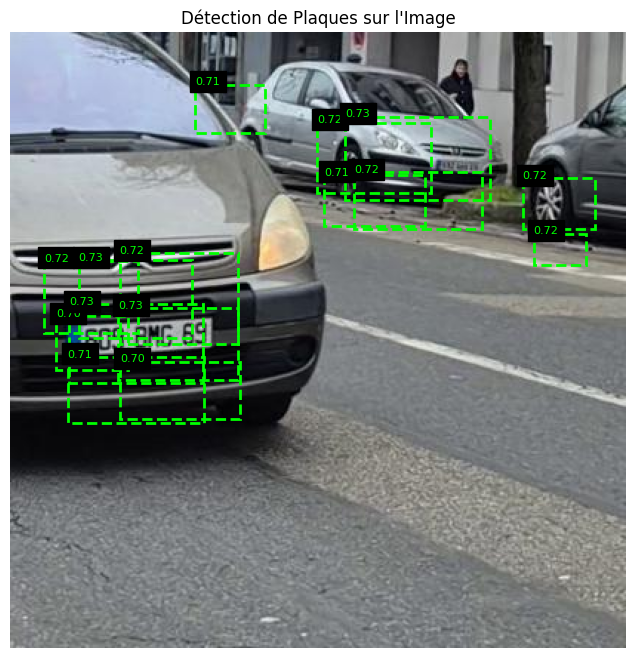

In [33]:
# Chemin vers la frame
frame_path = os.path.join("/kaggle/working/video_frames_cropped", "frame_00050.jpg")

# Affichage des prédictions
show_pred_image(
    model=model,
    img_path=frame_path,
    transform=my_transforms,   # ton pipeline de resize + ToTensor
    S=13,
    IMG_SIZE=416,
    conf_thresh=0.7           # tu peux ajuster à 0.3 ou 0.5 selon la qualité
)


In [34]:
# Apply the YOLO model on the cropped images and save the results with bounding boxes

def apply_yolo_on_images(input_folder, output_folder, model, transform, device, conf_thresh=0.7):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    model.eval()

    for img_name in os.listdir(input_folder):
        img_path = os.path.join(input_folder, img_name)
        img = Image.open(img_path).convert("RGB")
        img_transformed = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(img_transformed)[0].cpu() 
        p_boxes, p_scores, p_classes = decode_yolo_grid(pred, S=13, is_target=False)
        mask = p_scores > conf_thresh
        p_boxes, p_scores, p_classes = p_boxes[mask], p_scores[mask], p_classes[mask]
        keep = apply_nms(p_boxes, p_scores)
        p_boxes, p_scores, p_classes = p_boxes[keep], p_scores[keep], p_classes[keep]
        fig, ax = plt.subplots(1)
        ax.imshow(img)

        for box, sc in zip(p_boxes, p_scores):
            x, y, w, h = box
            x0 = (x - w/2) * img.width
            y0 = (y - h/2) * img.height
            w0 = w * img.width
            h0 = h * img.height

            rect = patches.Rectangle((x0, y0), w0, h0, linewidth=2, edgecolor='lime', facecolor='none', linestyle='--')
            ax.add_patch(rect)
            ax.text(x0, y0, f"{sc:.2f}", color='lime', fontsize=8, backgroundcolor='black')
        plt.axis('off')
        plt.savefig(os.path.join(output_folder, img_name), bbox_inches='tight', pad_inches=0)
        plt.close()
    print(f"Processed images saved in '{output_folder}'.")

In [35]:
input_folder = "/kaggle/working/video_frames_cropped"
output_folder = "/kaggle/working/video_frames_yolo"
apply_yolo_on_images(input_folder, output_folder, model, my_transforms, device, conf_thresh=0.7)

Processed images saved in '/kaggle/working/video_frames_yolo'.


In [36]:
# reconstruct the video from the processed frames

def frames_to_video(input_folder, output_video_path, fps=10):
    frame_files = sorted([f for f in os.listdir(input_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    if not frame_files:
        print("Aucune image trouvée dans le dossier spécifié.")
        return

    first_frame = cv2.imread(os.path.join(input_folder, frame_files[0]))
    height, width, layers = first_frame.shape

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    for frame_file in frame_files:
        frame_path = os.path.join(input_folder, frame_file)
        frame = cv2.imread(frame_path)
        video.write(frame)

    video.release()
    print(f"Vidéo créée avec succès : '{output_video_path}'.")

In [37]:
input_folder = "/kaggle/working/video_frames_yolo"
output_video_path = "/kaggle/working/yolo_detected_video.mp4"

frames_to_video(input_folder, output_video_path, fps=10)

Vidéo créée avec succès : '/kaggle/working/yolo_detected_video.mp4'.


[ WARN:0@291.343] global cap_ffmpeg.cpp:198 write FFmpeg: Failed to write frame
[ WARN:0@291.344] global cap_ffmpeg.cpp:198 write FFmpeg: Failed to write frame
